<a href="https://colab.research.google.com/github/andreavitaletti/colab/blob/main/programming_differential_privacy%20/notebooks/chap3_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original: https://desfontain.es/blog/differential-privacy-in-practice.html

# Counting unique users

Suppose you have a database, and you want to publish how many people in there satisfy a given condition. Say, how many are 40 ?

You can't just publish the true answer. Let's take a moment to understand why.

**With differential privacy, we assume that the attacker knows almost all elements. They only have uncertainty about their target.** Say they want to know whether their target is 40. If you output the real number k
, they can compare it with the number of people with age 40 among the people they know. If it's k−1, then the target is 40. If it's k, then the target does not.

So, what do we do? We compute the exact answer, and **we add noise**. This noise will come from a probability distribution called the Laplace distribution. This distribution has a parameter, its scale, which determines how "flat" it is. It looks like this:

![](https://desfontain.es/blog/images/laplace-ln-3.svg)


Graph showing a Laplace distribution with scale 1/ln($\epsilon$), centered on 0
So, to get $\epsilon$-differential privacy, we pick a random value according to Laplace(1/$\epsilon$), and we add this noise to the real value.

Why does it work? Let's look at the distribution of the number we return, depending on whether the true count is k=1000 (blue line, the target isn't 40) or k=1001 (yellow line, the target is 40).

![](https://desfontain.es/blog/images/two-laplace-ln-3.svg)

Graph showing two Laplace distributions with scale 1/ln($\epsilon$), centered on 1000 and 1001
Let's say the real number is k=1001
, and after adding noise, we published 1003
. Let's put ourselves in the attacker's shoes. What's the likelihood that the original number was 1001
 vs. 1000
? The hypothesis "k=1001
" is a bit more likely: generating a noise of 2
 is more likely than a noise of 3
. How much more likely? It turns out that the ratio between these likelihoods is... $e^\epsilon$.! So the ratio of probabilities of differential privacy is satisfied.

This works no matter what the output is: the ratio will always be between eε
 and $e^\epsilon$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
adult = pd.read_csv("https://github.com/uvm-plaid/programming-dp/raw/master/notebooks/adult_with_pii.csv")

PDF for x = 0.0: 0.5


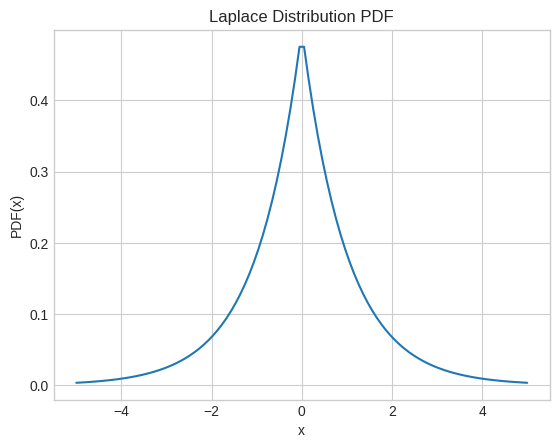

In [25]:
from scipy import stats

# Define location (mean) and scale parameters
loc = 0
scale = 1.0

# Create a Laplace distribution object
laplace_dist = stats.laplace(loc, scale)

# Calculate the PDF for a specific value (x = 3.0)
x = 0.0
pdf_value = laplace_dist.pdf(x)

print(f"PDF for x = {x}: {pdf_value}")

# Alternatively, calculate the PDF for an array of values
x_values = np.linspace(-5.0, 5.0, 100)
pdf_values = laplace_dist.pdf(x_values)

# Plot the PDF (using matplotlib)
import matplotlib.pyplot as plt

plt.plot(x_values, pdf_values)
plt.xlabel("x")
plt.ylabel("PDF(x)")
plt.title("Laplace Distribution PDF")
plt.show()

In [3]:
adult[adult['Age'] == 40].shape[0]

514

In [5]:
sensitivity = 1
epsilon = 0.1

adult[adult['Age'] == 40].shape[0] + np.random.laplace(loc=0, scale=sensitivity/epsilon)

513.2012526632881

In [7]:
forties = adult[adult['Age'] == 40]
forties.head(10)

,Name,DOB,SSN,Zip,Workclass,Education,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Hours per week,Country,Target,Age,Capital Gain,Capital Loss
41,Theo Fearney,1/22/1983,439-28-9935,95683,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,40,United-States,<=50K,40,0,0
64,Rebeka Casali,9/23/1983,789-15-5786,16447,Private,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,<=50K,40,0,0
130,Lucienne Bjerkan,7/22/1983,291-44-4348,90907,NaN,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,40,United-States,<=50K,40,0,0
159,Rodina Lawlings,4/21/1983,103-24-4654,63643,Self-emp-not-inc,Some-college,10,Separated,Sales,Unmarried,Black,Male,2,United-States,<=50K,40,0,1816
168,Faustine Harris,8/13/1983,470-53-4203,83031,Federal-gov,Assoc-acdm,12,Never-married,Exec-managerial,Not-in-family,White,Male,42,United-States,<=50K,40,0,0
238,Leanna Conor,8/20/1983,798-82-1662,38496,State-gov,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,38,United-States,<=50K,40,0,0
254,Sampson Deboick,7/27/1983,347-52-7988,32825,Local-gov,10th,6,Widowed,Other-service,Unmarried,Black,Female,30,United-States,<=50K,40,0,0
267,Kerwin O'Keefe,9/11/1983,453-01-6150,69315,Self-emp-inc,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,75,Thailand,>50K,40,0,0
282,Melessa Franceschelli,3/13/1983,886-19-8474,70124,Private,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,15,Germany,<=50K,40,0,0
302,Randolph Renihan,10/13/1983,497-37-9432,22079,Private,Bachelors,13,Married-civ-spouse,Adm-clerical,Husband,White,Male,40,United-States,>50K,40,7688,0


# How Much Noise is Enough?

How do we know that the Laplace mechanism adds enough noise to prevent the re-identification of individuals in the dataset? For one thing, we can try to break it! Let's write down a malicious counting query, which is specifically designed to determine whether Melessa Franceschelli is 40.

In [10]:
melissa_row = adult[adult['Name'] == 'Melessa Franceschelli']
melissa_row[melissa_row['Age'] == 40].shape[0]

1

This result definitely violates Melissa's privacy, since it reveals the value of the age column for Melissa's row. Since we know how to ensure differential privacy for counting queries with the Laplace mechanism, we can do so for this query:

In [15]:
sensitivity = 1
epsilon = 0.1

melissa_row = adult[adult['Name'] == 'Melessa Franceschelli']
melissa_row[melissa_row['Age'] == 40].shape[0] + \
  np.random.laplace(loc=0, scale=sensitivity/epsilon)

-23.11404647983713

Is the true answer 0 or 1? There's too much noise to be able to reliably tell. This is how differential privacy is intended to work - the approach does not reject queries which are determined to be malicious; instead, it adds enough noise that the results of a malicious query will be useless to the adversary.

**Randomness and Replicability**

This example uses randomized algorithms, particularly when demonstrating differentially private mechanisms that add noise to data or model updates. Because we do not fix a random seed, the exact output of these examples will vary from one run to another. This variability is expected and is a natural consequence of differential privacy, which depends on randomness to provide protection.

If your results differ slightly from those shown in the book, that’s not a bug—it’s a feature. The underlying behavior of the algorithm should remain consistent, even if the exact numbers vary. If you need to replicate results exactly (for testing or debugging), you can set a fixed seed using tools like `np.random.seed()` or `random.seed()` in Python. For instructional purposes, however, we choose not to fix seeds so that the examples reflect the true behavior of private algorithms in practice.
